In [ ]:
from liblet import Tree, Grammar, Derivation, ProductionGraph, side_by_side, closure

# Fare pulizia nelle CF

## Una nozione di chiusura

Applicare il decoratore [@closure](https://liblet.readthedocs.io/en/latest/api.html#liblet.decorators.closure) ad una funzione `f`  produce una funzione `F` che corrisponde all'applicazione di `f` iterata sino a quando l'argomento ed il valore restituito da quest'ultima coincidono.

In [ ]:
@closure
def add_smaller(S):
    return S | {x - 1 for x in S if x > 0}

In [ ]:
add_smaller({3, 5})

{0, 1, 2, 3, 4, 5}

## Eliminare simboli non produttivi e/o irraggiungibili

In [ ]:
# fig 2.27, pag. 49

G = Grammar.from_string("""
S -> A B | D E
A -> a
B -> b C
C -> c
D -> d F 
E -> e 
F -> f D
""")
G

Grammar(N={A, B, C, D, E, F, S}, T={a, b, c, d, e, f}, P=(S -> A B, S -> D E, A -> a, B -> b C, C -> c, D -> d F, E -> e, F -> f D), S=S)

In [ ]:
@closure
def productive(prod, G):
    for P in G.P:
        if set(P.rhs) <= prod: prod |= {P.lhs}
    return prod

productive(G.T, G)

frozenset({'A', 'B', 'C', 'E', 'S', 'a', 'b', 'c', 'd', 'e', 'f'})

In [ ]:
@closure
def reachable(reach, G):
    for P in G.P:
        if P.lhs in reach: reach |= set(P.rhs)
    return reach
    
reachable({G.S}, G)   

{'A', 'B', 'C', 'D', 'E', 'F', 'S', 'a', 'b', 'c', 'd', 'e', 'f'}

### <span style="color: red;">Per casa</span>: l'ordine conta!

* Implementare una versione del *decoratore* `closure`.

* Implementare una funzione `clean(G, good)` che data una grammatica `G` e un 
  insieme di   simboli `good` restituisca una nuova grammatica ottenuta cancellando 
  da `G` i simboli non in `good` e le produzioni in cui figurano.

In [ ]:
G_small = Grammar.from_string("""
S -> A | a
A -> A B
B -> a
C -> a
B -> x
""")

Ad esempio, se invocata su `G_small` e avendo `{'A', 'B', 'S', 'a'}` come insieme di simboli da preservare, la funzione restituisce la grammatica `Grammar(N={A, B, S}, T={a}, P=(S -> A, S -> a, A -> A B, B -> a), S=S)`
  
* Usando tale funzione, mostrare che, dati 
  
        G0 = clean(G, productive(G.T, G))
        G1 = clean(G0, reachable({G0.S}, G0))
      
        G2 = clean(G, reachable({G.S}, G))
        G3 = clean(G2, productive(G2.T, G2))
        
  si ha che `G1` e`G3` sono diverse, ossia che rimuovere prima gli improduttivi e poi 
  gli irraggiungibili, o viceversa, non porta alla stessa grammatica (e solo `G1` è
  una grammatica *propria*).

# Derivazioni e alberi di parsing

In [ ]:
# una grammatica banale per il linguaggio {'ab'}

G_ab = Grammar.from_string("""
S -> A B
A -> a
B -> b
""")
G_ab

Grammar(N={A, B, S}, T={a, b}, P=(S -> A B, A -> a, B -> b), S=S)

In [ ]:
# due possibili derivazioni

ab_0 = Derivation(G_ab).step([
    (0, 0), (2, 1), (1, 0)
])
ab_1 = Derivation(G_ab).step([
    (0, 0), (1, 0), (2, 1)
]) 

ab_0, ab_1

(S -> A B -> A b -> a b, S -> A B -> a B -> a b)

In [ ]:
# ma a ben guardare lo stesso albero…

side_by_side(
    ProductionGraph(ab_0),
    ProductionGraph(ab_1),
)    

## Dalla derivazione all'albero di parsing

La seguente procedura memorizza in `sentence` la forma sentenziale a cui è giuta la derivazione (di passo in passo) come una tupla di alberi annotati (rappresentati come una *lol*). 

Ciascun nodo dell'albero ha due etichette: `Symbol` che si riferisce ad uno dei simboli della grammatica e `nprord` pari ad un numero di produzione. I figli di ciascun nodo hanno i simboli contenuti nel lato destro della produzione di numero `nprord`.

Gli alberi vengono "completati" man mano che la procedura elabora i passi della derivazione; al termine le foglie degli alberi saranno simboli terminali (e `nprord` sarà convenzionalmente definito come `None`).

In [ ]:
def derivation_to_parsetree(d):
    # questa variabile si riferià all'albero di derivazione di d
    root = [{'Symbol': d.G.S, 'nprod': None}]
    # all'inizio la forma sentenziale è data dal simbolo distinto
    sentence = [root, ] 
    for prod, pos in d.steps():
        # l'albero corrente è deciso dalla posizione 
        # in cui è applicata la produzione
        tree = sentence[pos]
        # i figli sono dati dal lato destro d.G.P[prod].rhs
        children = [[{'Symbol': X, 'nprod': None}] for X in d.G.P[prod].rhs]
        # si aggiorna il valore di nprod e si aggiungono i figli all'albero
        tree[0]['nprod'] = prod
        tree.extend(children)
        sentence = sentence[:pos] + children + sentence[pos + 1:]
    return root

In [ ]:
pt_0 = derivation_to_parsetree(ab_0)
pt_0

[{'Symbol': 'S', 'nprod': 0},
 [{'Symbol': 'A', 'nprod': 1}, [{'Symbol': 'a', 'nprod': None}]],
 [{'Symbol': 'B', 'nprod': 2}, [{'Symbol': 'b', 'nprod': None}]]]

In [ ]:
# l'albero di parsing prodotto da liblet, e da derivation_to_parsetree

side_by_side(
    ProductionGraph(ab_0),
    Tree.from_lol(pt_0)
)

### <span style="color: red;">Per casa:</span> dall'albero alle derivazioni left/right-most

Le derivazioni leftmost e rightmost si possono ottenere, rispettivamente, tramite una visita in preordine e postordine dell'albero di parsing.

In [ ]:
def leftmost_from_parsetree(tree):
    result = []
    def visit(node):
        root, *children = node
        nprod = root['nprod']
        if nprod is not None: result.append(nprod)
        for child in children: visit(child)
    visit(tree)
    return result

leftmost_from_parsetree(pt_0)

[0, 1, 2]

In [ ]:
def rightmost_from_parsetree(tree):
    result = []
    def visit(node):
        root, *children = node
        nprod = root['nprod']
        if nprod is not None: result.append(nprod)
        for child in reversed(children): visit(child)
    visit(tree)
    return result

rightmost_from_parsetree(pt_0)

[0, 2, 1]

### <span style="color: red;">Per casa</span>: le ϵ-produzioni

In alcuni casi sono comode produzioni della forma $A\to \epsilon$ (chiamate ϵ-produzioni). Nella costruzione dell'albero dalla derivazione richiedono però un po' di attenzione…

Consideriamo ad esempio il caso del [linguaggio di Dyck](https://en.wikipedia.org/wiki/Dyck_language)

In [ ]:
G_dyck = Grammar.from_string('S -> S S | ( S ) | ε')

In [ ]:
# una derivazione leftmost di '(())'

dyck = 0, 1, 1, 2, 2

deriv = Derivation(G_dyck).leftmost(dyck)
deriv

S -> S S -> ( S ) S -> ( ( S ) ) S -> ( ( ) ) S -> ( ( ) )

In [ ]:
# la parola 
''.join(deriv.sentential_form())

'(())'

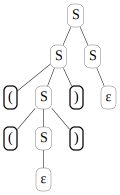

In [ ]:
# l'albero 

ProductionGraph(deriv)

Applicando la funzione `derivation_to_parsetree` si nota però un errore: sembra che da `)` derivi ϵ!

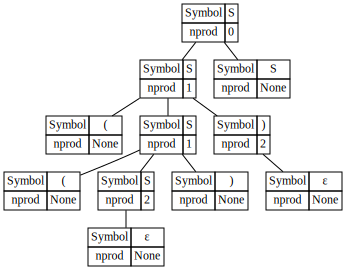

In [ ]:
Tree.from_lol(derivation_to_parsetree(deriv)) 